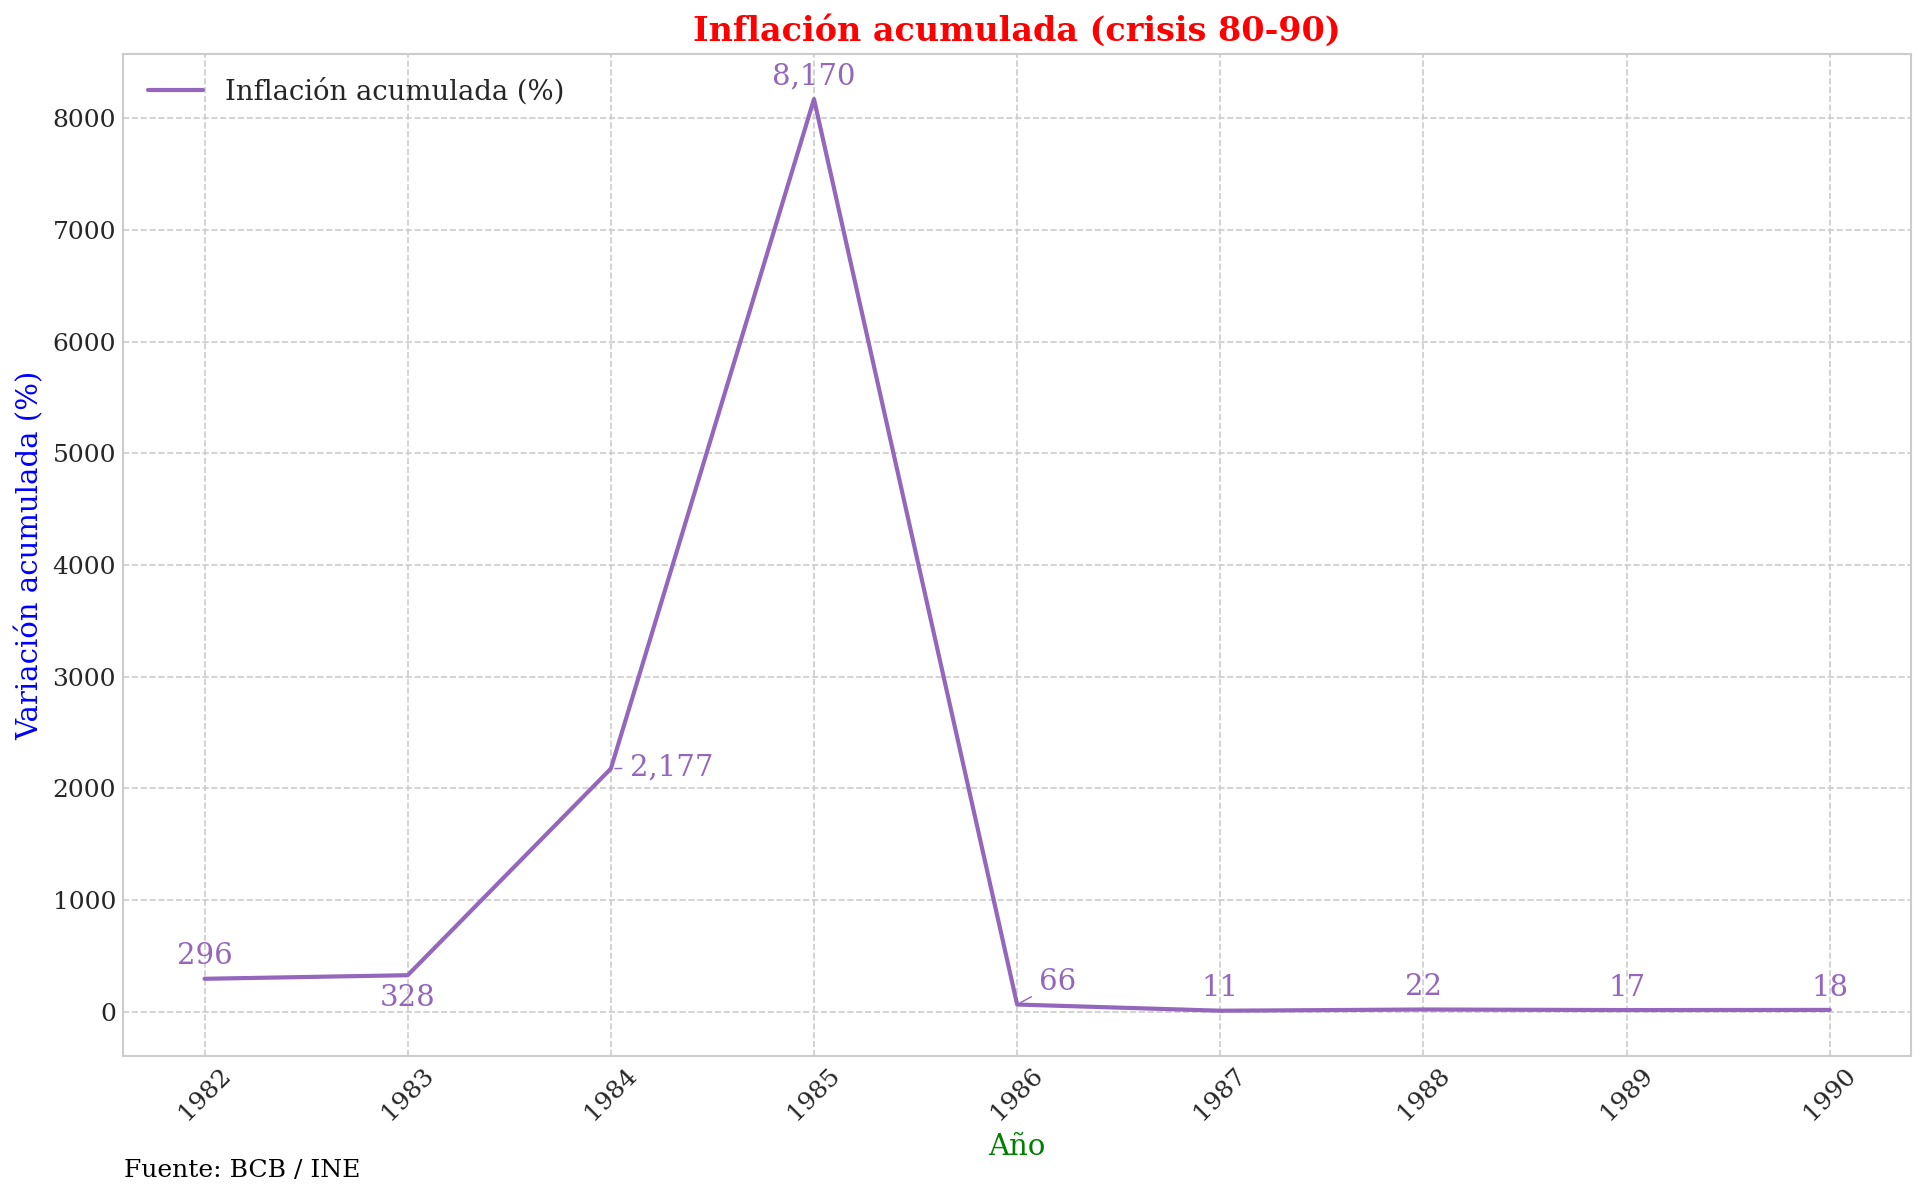

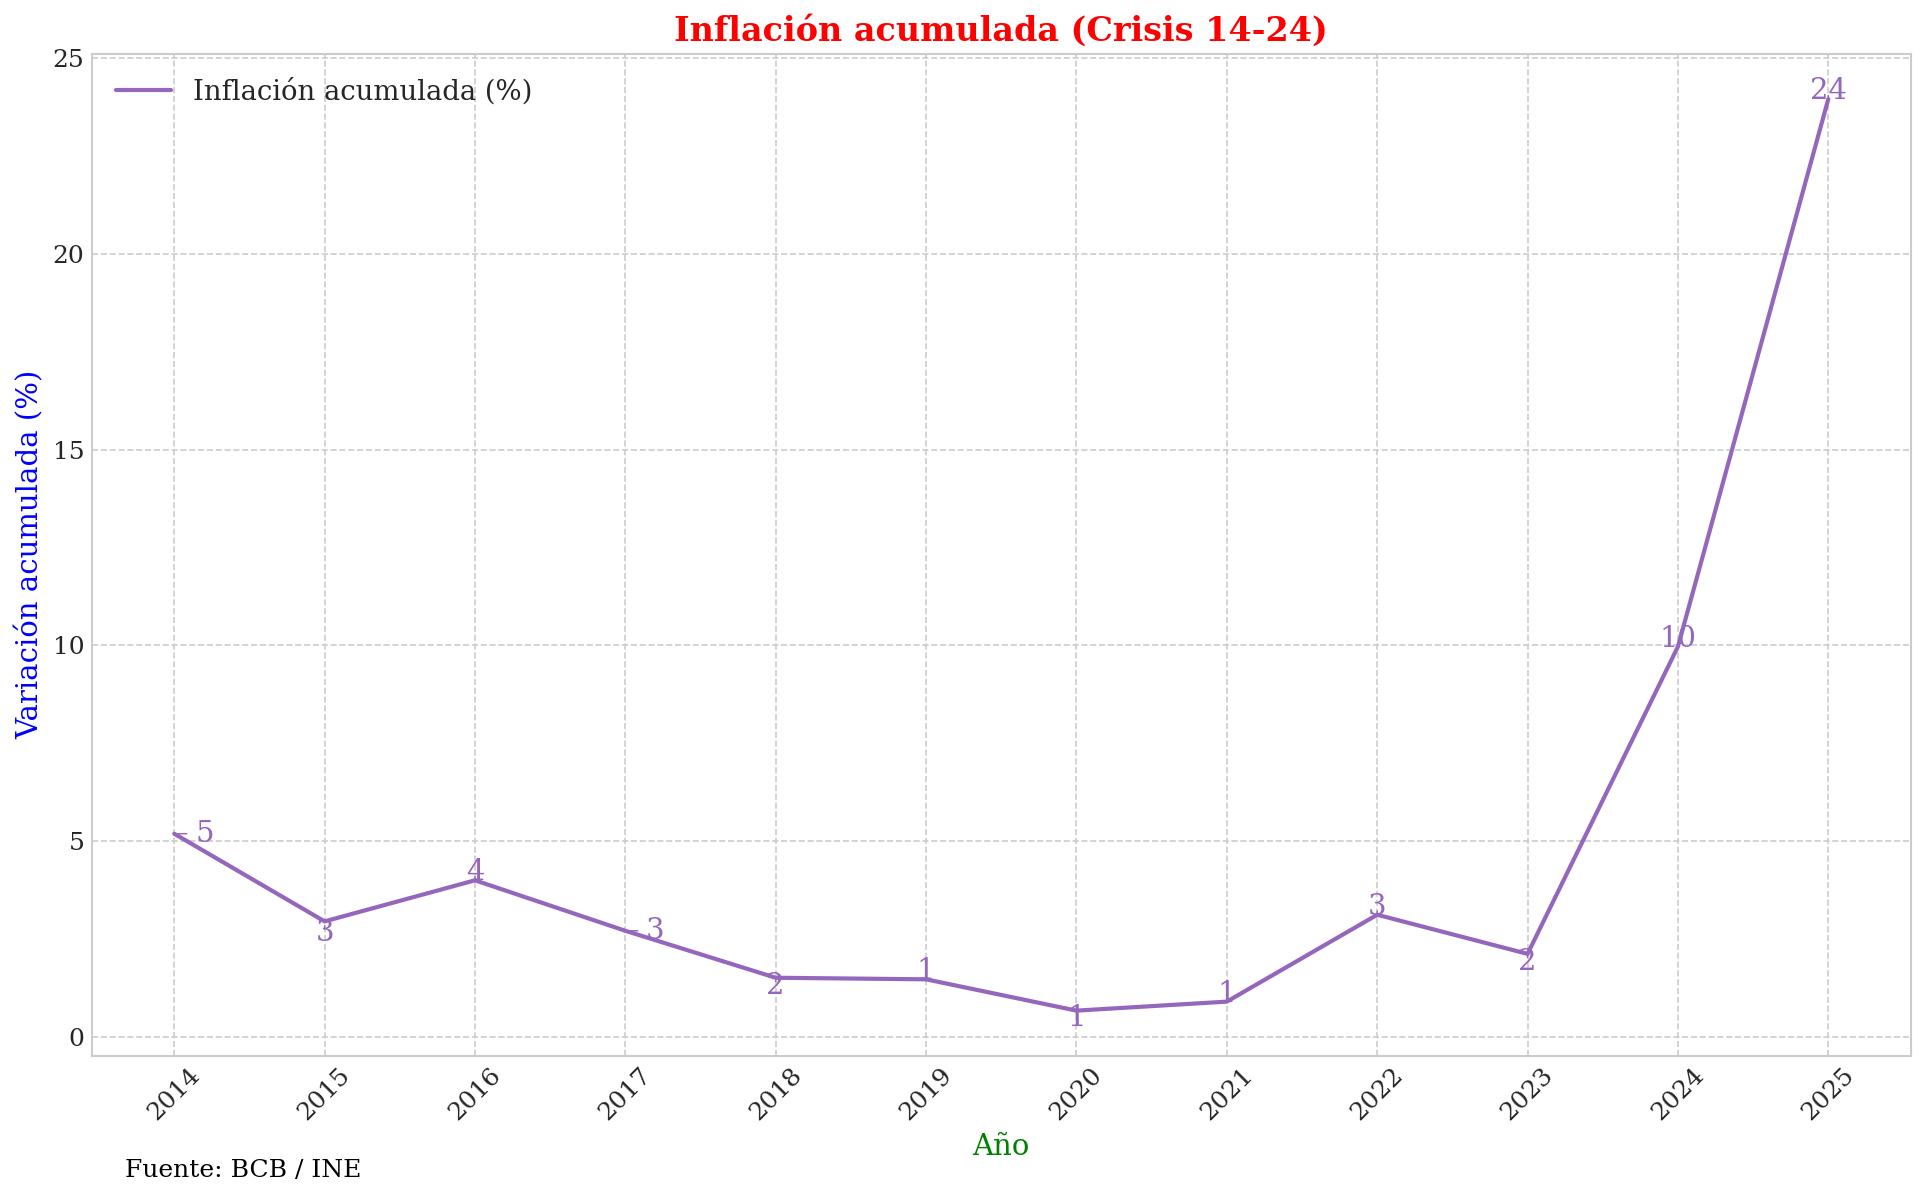

In [2]:
# ─────────────────────────────────────────────────────────────────────
# Importaciones
# ─────────────────────────────────────────────────────────────────────
import sys, os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Si aún no instalaste el paquete en editable, descomenta:
# sys.path.append(os.path.abspath('../'))

from func_auxiliares.graficos_utils import (
    get_df, set_style, init_base_plot,
    add_year_value_annotations
)
from func_auxiliares.config import (
    DB_PATH, ASSETS_DIR, PERIODOS_PARA_CRISIS
)

# ─────────────────────────────────────────────────────────────────────
# Configuración general
# ─────────────────────────────────────────────────────────────────────
output_dir = ASSETS_DIR / "crisis" / "inflacion_acumulada"
output_dir.mkdir(parents=True, exist_ok=True)

set_style()

# ─────────────────────────────────────────────────────────────────────
# Carga de datos
# ─────────────────────────────────────────────────────────────────────
SQL = """
    SELECT
      año,
      inflacion
    FROM inflacion_acumulada
"""
df = get_df(SQL, str(DB_PATH), index_col="año")
df.loc[2025, "inflacion"] = 23.96 # Asegura que 2025 no tenga datos
# ─────────────────────────────────────────────────────────────────────
# Componentes y parámetros de graficado
# ─────────────────────────────────────────────────────────────────────
componentes      = [("inflacion", "Inflación acumulada (%)")]
cols_componentes = [col for col, _ in componentes]
colors           = {"inflacion": "#9467bd"}

# ─────────────────────────────────────────────────────────────────────
# Offsets y años extra para anotaciones
# ─────────────────────────────────────────────────────────────────────
# Define desplazamientos (x_offset, y_offset) para cada año posible
annotation_offsets = {
    "inflacion": {
        1982: (0,  200),
        1983: (0,  -200),
        1984: (0.3,  10),
        1985: (0,  200),
        1986: (0.2,  200),
        1987: (0, 200),   
        1988: (0,  200),
        1989: (0,  200),
        1990: (0,  200),

        2014: (0.2,  0),  
        2015: (0,  -0.3),   
        2016: (0, 0.2),   
        2017: (0.2,  0),
        2018: (0,  -0.2),
        2019: (0,  0.2),
        2020: (0, -0.2),
        2021: (0,  0.2),   
        2022: (0,  0.2),
        2023: (0,  -0.2),
        2024: (0,  0.2), 
        2025: (0,  0.2),  # Asegura que 2025 tenga un offset  
    }
}


# ─────────────────────────────────────────────────────────────────────
# Generación de gráficas por subperíodo de crisis
# ─────────────────────────────────────────────────────────────────────
for nombre, (ini, fin) in PERIODOS_PARA_CRISIS.items():
    # Recorta al rango disponible en df
    sub = df.loc[ini:fin]
    if sub.empty:
        continue  # salta si no hay datos en ese rango
    #si sub tiene solo 3 datos
    if len(sub) < 4:
        print(f"Subperíodo {nombre} tiene menos de 3 datos, omitiendo.")
        continue

    # Calcula años a anotar: siempre ini/fin + extras dentro del rango
    years_to_annot = list(sub.index)  # Aquí tomas los años directamente del índice del DataFrame

    fig, ax = init_base_plot(
        sub,
        series=componentes,
        colors=colors,
        title=f"Inflación acumulada ({nombre})",
        xlabel="Año",
        ylabel="Variación acumulada (%)",
        source_text="Fuente: BCB / INE"
    )

    add_year_value_annotations(
        ax,
        sub,
        years_to_annot,
        cols_componentes,
        annotation_offsets,
        colors,
        arrow_lw=0.7
    )

    fig.savefig(output_dir / f"inflacion_acumulada_{nombre}.png")
    plt.show()  # Muestra la gráfica en pantalla
    plt.close(fig)

 

In [3]:
df

,inflacion
año,
1982,296.50
1983,328.50
1984,2177.20
1985,8170.50
1986,66.00
1987,10.70
1988,21.50
1989,16.60
1990,18.00
